In [ ]:
import numpy as np
from glob import glob
from skimage import data, io
import scipy.io as sio
from matplotlib import pyplot as plt
from random import choice, randint
from pathlib import PurePath
from shutil import copy, move
import os
from tqdm.notebook import tqdm
import albumentations as A
import cv2
import pandas as pd
from sklearn.utils import shuffle
from catalyst.utils import imread

In [280]:
mask_path = "cats_masks/{}"
image_path = "cats_images/{}.jpg"
annotation_list = list(glob("cats_annotation/*"))
cats_list = list(glob("cats_images/*"))
non_cats_list = list(glob("non_cats_images/*"))

annotation_list[:5]
cats_list[:5]
non_cats_list[:5]

['non_cats_images/2008_000336.jpg',
 'non_cats_images/2009_001251.jpg',
 'non_cats_images/2009_000938.jpg',
 'non_cats_images/2011_005460.jpg',
 'non_cats_images/2011_001820.jpg']

In [ ]:
cats_set = set(map(lambda x: PurePath(x).stem, cats_list))
annot_set = set(map(lambda x: PurePath(x).stem, annotation_list))

cats_set - annot_set
  

In [ ]:
h = 10000
w = 10000
for annotation in tqdm(annotation_list):
    st = PurePath(annotation).stem
    im_path = image_path.format(st)
    im = io.imread(im_path)
    mask = []
    try:
        mat_file = sio.loadmat(annotation)
        mask = create_mask(mat_file)
    except IndexError:
        print(f"index error {st}")
        bad_im.append(st)
    
    if mask.sum() == np.prod(im.shape[:2]):
        h_, w_ = im.shape[:2]
        if h_ < h:
            h = h_
        if w_ < w:
            w = w_
        
        
#         np.save(mask_path.format(st), mask)

    else:
        print(f"shape error {st}")
        print(mask.sum(), np.prod(im.shape[:2]))
        bad_im.append(st)
        
        
print(h, w) 

In [ ]:
df = pd.DataFrame(columns = ['image', 'mask'])
for i in annotation_list:    
    st = PurePath(i).stem
    im = image_path.format(st)
    df = df.append({'image' : im, 'mask' : i},ignore_index = True) 
df.to_csv("trainval.csv", index=None)

In [ ]:
df = pd.read_csv("trainval.csv")
for i in non_cats_list:    
    df = df.append({'image' : i,},ignore_index = True) 
df.to_csv("trainval.csv", index=None)

In [ ]:
df[:1001]

In [ ]:
def create_datset(df, train_p=0.7, val_p=0.15, test_p=0.15):
    df_c = df[~df['mask'].isna()].copy()
    df_nc = df[df['mask'].isna()].copy()
    
    df_c = shuffle(df_c)
    df_nc = shuffle(df_nc)
    
    df_ctr = df_c[:int(len(df_c) * train_p)]
    df_cvl = df_c[int(len(df_c) * train_p):int(len(df_c) * (train_p + val_p))] 
    df_cts = df_c[int(len(df_c) * (train_p + val_p)):] 
    
    df_nctr = df_nc[:int(len(df_nc) * train_p)]
    df_ncvl = df_nc[int(len(df_nc) * train_p):int(len(df_nc) * (train_p + val_p))] 
    df_ncts = df_nc[int(len(df_nc) * (train_p + val_p)):]    
    
    
    shuffle(pd.concat([df_ctr, df_nctr])).to_csv("train.csv", index=None)
    shuffle(pd.concat([df_cvl, df_ncvl])).to_csv("val.csv", index=None)
    shuffle(pd.concat([df_cts, df_ncts])).to_csv("test.csv", index=None) 
    
    
    
create_datset(df[:1001], train_p=0.8, val_p=0.2, test_p=0)

In [ ]:
df_tr = pd.read_csv("train.csv")
df_val = pd.read_csv("val.csv")
df_test = pd.read_csv("test.csv")
set(df_tr['image']) & set(df_val['image'])



cats_annotation/2010_004479.mat
(375, 500)
['person']
(375, 500, 3)


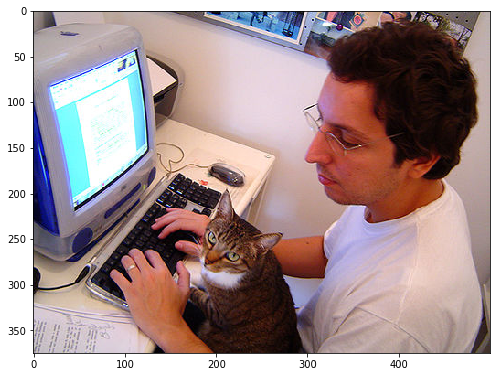

In [282]:
plt.figure(figsize=(7, 7))
n = randint(0, len(annotation_list) - 1)
# n = 20
# n = annotation_list.index("cats_annotation/2009_004813.mat")
annotation = annotation_list[n]

print(annotation_list[n])
im_path = image_path.format(PurePath(annotation).stem)
im = io.imread(im_path)
mat_file = sio.loadmat(annotation)
print(mat_file['anno'][0][0][1][0][0][2].shape)
print(mat_file['anno'][0][0][1][0][0][0])
print(im.shape)
io.imshow(im_path);

In [ ]:
s = "head lear rear leye reye nose torso neck lfleg lfpa rfleg rfpa lbleg lbpa rbleg rbpa tail"
classes_map = {i : k+1 for k, i in enumerate(s.split())}
classes_map['background'] = 0
classes_map

In [284]:
def create_mask(mat_file):
    list_classes = mat_file['anno'][0][0][1][0]
    
    w, h = list_classes[0][2].shape    
    out_array = np.zeros([18, w, h], dtype='int')
    out_array[0] = np.ones([w, h], dtype="int")
    
    insert_classes = [0]
    for k, i in enumerate(list_classes):
        if i[0][0] == 'cat':         
            for i in list_classes[k][3][0]:                
                index = classes_map[i[0][0]]
                out_array[index] += i[1].copy()
                if index not in insert_classes:
                    insert_classes.append(index)
                
            
    out_array = out_array.clip(0, 1)
#     print(out_array.sum())
    
    insert_classes.sort()
#     print(insert_classes)
    for i in range(len(insert_classes)-1):
        for j in range(i+1, len(insert_classes)):            
            out_array[insert_classes[i]] -= out_array[insert_classes[j]]
        
    return np.transpose(out_array.clip(0, 1).astype(np.uint8),[1, 2, 0])


mask = create_mask(mat_file)
mask;
print(mask.sum())
print(np.prod(im.shape[:2]))

187500
187500


1


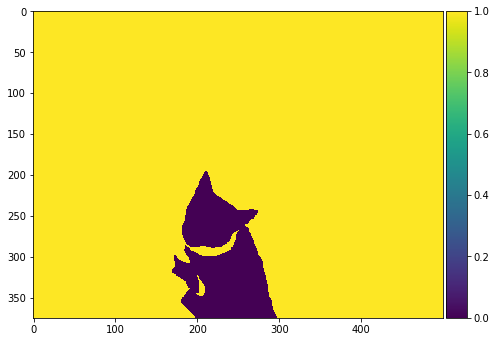

In [285]:
plt.figure(figsize=(7, 7))
l = 0
io.imshow(mask[:,:,l])
print(mask[l].max())
# type(mask[l])

In [263]:
colors = np.random.randint(0, high=192, size=(18, 1, 3), dtype=np.uint8)


In [ ]:
np.save("color_scheme", colors)


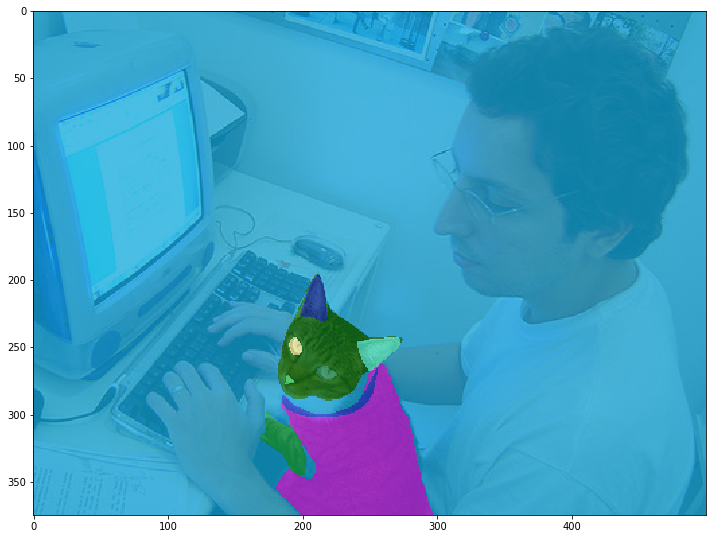

In [286]:
plt.figure(figsize=(10, 10))


def mask_attachment_new(im, mask):
    new_im = im // 4
    for k in range(len(mask[0][0])):
        mask_3 = np.stack(([mask[:,:,k]] * 3), axis=2) * colors[k]
        new_im += mask_3
    return new_im

new_im = mask_attachment_new(im, mask)
io.imshow(new_im);




In [ ]:
mask_dim.sum()

In [ ]:
image_list = list(glob("cats_images/*"))
image_list[:10]
image_set = set(map(lambda x: PurePath(x).stem, image_list))
annotation_set = set(map(lambda x: PurePath(x).stem, annotation_list))

In [ ]:
# no_annotation = (image_set - annotation_set)
# for i in no_annotation:
#     os.remove(image_path.format(i))


In [ ]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

In [ ]:
plt.figure(figsize=(8, 8))
transform = A.Compose([
    A.Resize(width=512, height=512),
    A.RandomCrop(width=400, height=400),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

# Read an image with OpenCV and convert it to the RGB colorspace
image = cv2.imread(im_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Augment an image
transformed = transform(image=image, mask=mask)
transformed_image = transformed["image"]
transformed_mask = transformed["mask"]
# io.imshow(transformed_image);
# visualize(transformed_image, transformed_mask)
new_im = mask_attachment_new(transformed_image,  transformed_mask)
io.imshow(new_im);
np.product(transformed_image.shape[:2]) == transformed_mask.sum()

In [ ]:
np.product(transformed_image.shape[:2])

In [ ]:
transformed_mask.sum()

In [ ]:
transformed_mask.shape

In [ ]:
im = imread("test_images/700gc.jpg")
im.shape

In [ ]:
mask = np.array([[0, 1], [2, 3]])
mask = np.array([[0, 1], [2, 3]])
mask = mask.repeat(10, axis=0)
mask = mask.repeat(10, axis=1)

In [ ]:
import PIL
def colorize_mask(mask, palette):
    zero_pad = 256 * 3 - len(palette)
    for i in range(zero_pad):
                    palette.append(0)
    new_mask = PIL.Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)
    return new_mask

In [ ]:
palete = list(np.random.randint(255, size=12))
p = colorize_mask(mask, palete)

In [ ]:
len([31, 119, 180, 255, 127, 14, 44, 160, 44, 214, 39, 40, 148, 103, 189, 140, 86, 75, 227, 
    119, 194, 127, 127, 127, 188, 189, 34, 23, 190, 207, 31, 119, 180, 255, 127, 14, 44, 160, 44,
    214, 39, 40, 148, 103, 189, 140, 86, 75, 227, 119, 194, 127, 127, 127])

In [295]:
arr = np.random.randint(20, size=27).reshape(3, 3, 3).astype(float)
arr

array([[[ 5.,  3., 14.],
        [ 9., 15., 16.],
        [15., 17., 11.]],

       [[11., 18.,  1.],
        [19.,  9., 14.],
        [13., 17.,  9.]],

       [[15.,  6.,  7.],
        [ 0., 16.,  1.],
        [18., 12., 11.]]])

In [296]:
import torch
import torch.nn.functional as F
F.softmax(torch.from_numpy(arr), dim=0).argmax(0).cpu().numpy()

array([[2, 1, 0],
       [1, 2, 0],
       [2, 0, 0]])